# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Solucion

## procesamiento de datos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

C:\Users\DATT\AppData\Local\conda\conda\envs\ambiente\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
col = ["day","mean"]
mp = pd.DataFrame(columns = col)
checkerDuplicates = set()

for y in range(1995, 2019):
    if y == 2011:
        tmp = 0
    if y <= 2015:
        t = pd.read_excel('datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(y)+'.xlsx')
    else:
        t = pd.read_excel('datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(y)+'.xls')
    
    for i, row in t.iterrows():
        tmp1 = []
        if y == 2011:
            if tmp < 2:
                continue
            else: 
               tmp1 = [row[0], np.mean(row[1:-2]), row[-2]]
            tmp = tmp + 1
        else:
            if (i < 2):
                continue
            if y in [1995,1996,1997,1998,1999,2001,2002,2003,2004,2006,2007,2008,2009,]:
                tmp1 = [row[0], np.max(np.mean(row[1:]))]
            elif y in [2000,2005,2010,2015,2016,2017,2018]: 
                tmp1 = [row[0], np.mean(row[1:-1])]
            else:
                tmp1 = [row[0], np.mean(row[1:-2])]
        if tmp1[0] is np.nan:
            continue
        if not isinstance(tmp1[0], str):
            tmp1[0] = "{:%Y-%m-%d}".format(tmp1[0])
            
        if not tmp1[0] in checkerDuplicates:
            mp.loc[len(mp), :] = tmp1
            checkerDuplicates.add(tmp1[0])

In [3]:
mp.to_csv('allYearPrices.csv')

In [4]:
mp.head()

,day,mean
0,1995-07-20,1.40943
1,1995-07-21,4.92433
2,1995-07-22,1.2695
3,1995-07-23,0.953083
4,1995-07-24,4.30592


Realizar el modelo de regresión lineal con tf y encontrar la transformación mas precisa

In [5]:
amount = 24*7
dias = mp['day'].tolist()
precio = mp['mean'].tolist()

In [6]:
class Model(object):
    def __init__(self, L):        
        # Inicio mi vector de pesos
        self.w = tf.contrib.eager.Variable([0.0] * (L))

    def __call__(self, x):
        # Añado bias a mi entrada y lo múltiplico por mis pesos para
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        #  pesos
        y_pred = self(x)
        # calculo del error
        e = y_desired - y_pred
        # BIAS
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        # gradiente
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

## Reescalamiento al rango (0,1)

In [7]:
scaling = MinMaxScaler(feature_range = (0,1))
d = np.reshape(scaling.fit_transform(np.reshape(precio,(-1,1))),(-1,))

## Optimización de retardos

In [8]:
retardos = [2,3,4,5,6,7,8,10]

In [9]:
def optimizar_retardos(retardos,d):
    
    op_retardos = []

    for i in range(len(retardos)):

        L = retardos[i]

        model = Model(L)

        y_pred = np.empty(len(d))
        y_pred[:] = np.nan

        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=0.05, x=x, y_desired=d[t])

        op_retardos.append([d[-(amount):],y_pred[-(amount):]])
        
    return op_retardos

op_retardos = optimizar_retardos(retardos,d)

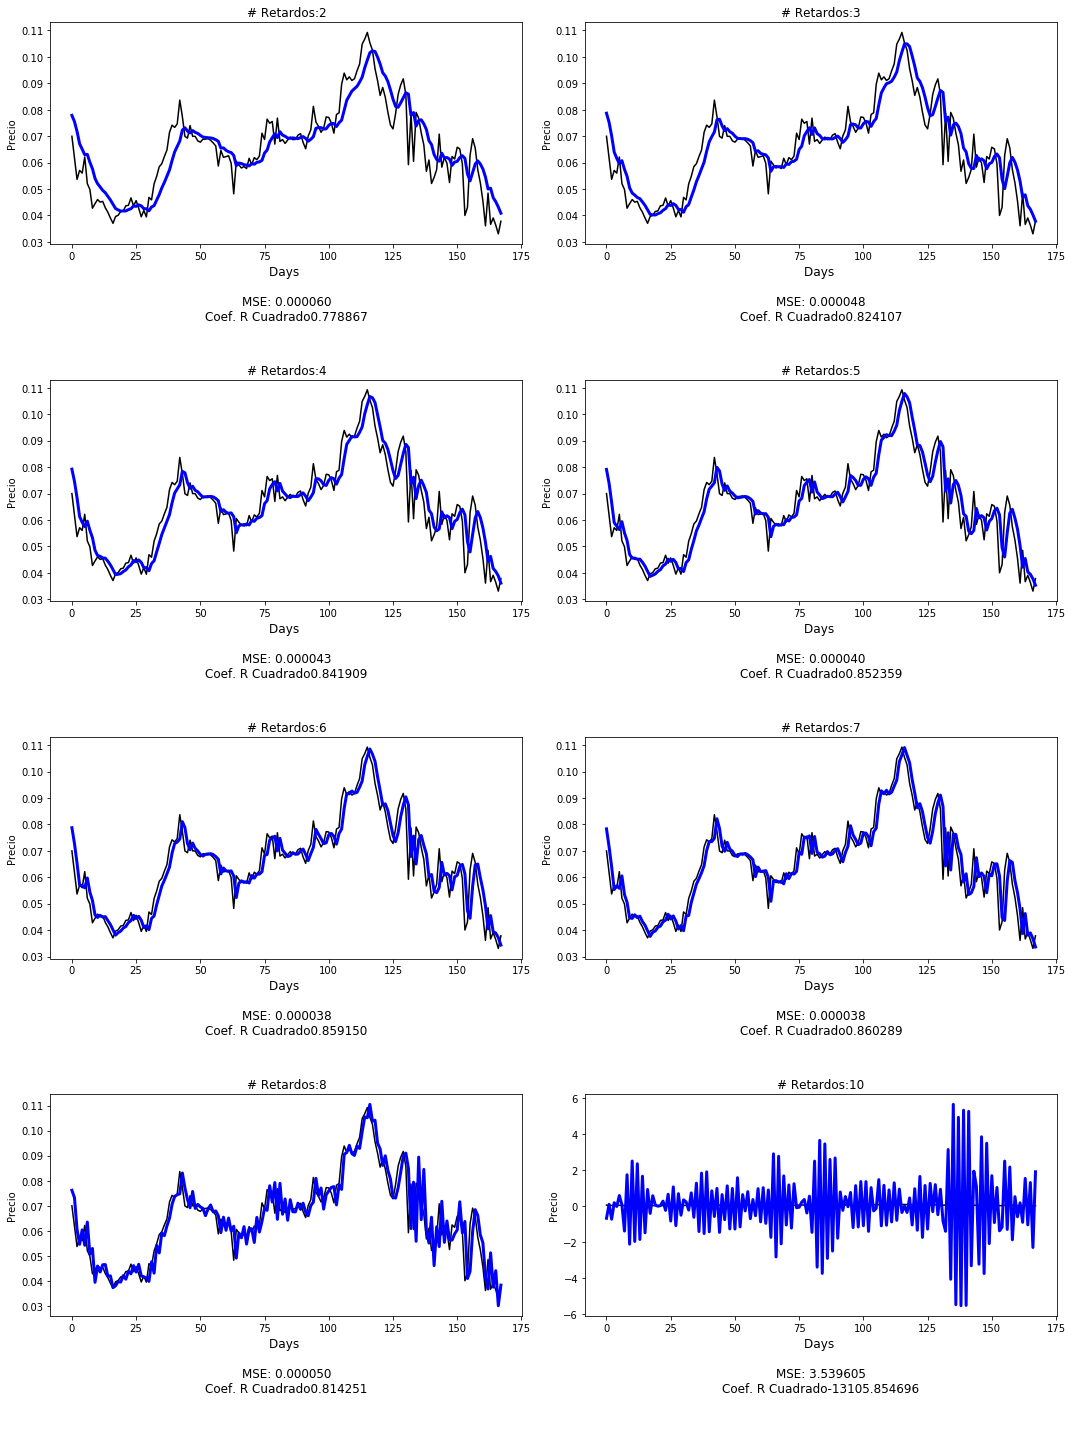

In [10]:
fig, coord = plt.subplots(nrows=4, ncols=2,figsize=(15,20))

iter = 0
for row in coord:
    for c in row:    
        titulo = str("retardo:"+str(retardos[iter])) 

        c.plot(op_retardos[iter][0],color = 'black',label = 'Real')
        c.plot(op_retardos[iter][1],color = 'blue',label = 'Prediccion',linewidth=3)

        c.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(op_retardos[iter][0],op_retardos[iter][1])))+'\n'+
                      str('Coef. R Cuadrado' + '{:f}'.format(r2_score(op_retardos[iter][0],op_retardos[iter][1]))+'\n \n'),fontsize=12) 

        c.set_ylabel('Precio')
        c.set_title(str('# Retardos:'+str(retardos[iter])),fontsize=12)

        fig    
        plt.tight_layout()

        iter=iter+1

In [11]:
learning_rate = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
op_learning_rate = []
L = 7
#predecir poximo valor desde 7 pasos atras
for i in range(len(learning_rate)):    
    model = Model(L)

    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=learning_rate[i], x=x, y_desired=d[t])

    op_learning_rate.append([d[-(amount):],y_pred[-(amount):]])


In [29]:
iter = 0
s = ''
try:
    for row in coord:
        for c in row:
            s = str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(op_learning_rate[iter][0],op_learning_rate[iter][1])))
            print(s)
            iter = iter +1
except IndexError as e:
    print('')
    

MSE: 0.000038
MSE: 0.000129
MSE: 0.000239
MSE: 0.001887
MSE: 0.001426



El error mas bajo se encuentra con la tasa de aprendizaje 0.05